In [116]:
import pandas as pd
import torch
from typing import Tuple, List
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.policies import BasePolicy
import onnx
import onnxruntime as ort
import numpy as np
from meta.custom_env import CustomEnv
from utils.fetch_data import Api, fetch_data

# Policy wrapper for ONNX export
class OnnxableSB3Policy(torch.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.policy(observation, deterministic=False)

def train_model(env, total_timesteps=10000) -> PPO:
    """Train a new PPO model"""
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=total_timesteps, log_interval=1000)
    return model

def export_model_to_onnx(model: PPO, save_path: str = "model.onnx"):
    """Export trained model to ONNX format"""
    onnx_policy = OnnxableSB3Policy(model.policy)
    observation_size = model.observation_space.shape
    dummy_input = torch.randn(1, *observation_size)
    
    torch.onnx.export(
        onnx_policy,
        dummy_input,
        save_path,
        opset_version=17,
        input_names=["input"],
    )
    
    # Verify the model
    onnx_model = onnx.load(save_path)
    onnx.checker.check_model(onnx_model)
    return save_path

def test_original_model(model: PPO, env: CustomEnv) -> List[float]:
    """Test the original model directly"""
    observation, info = env.reset()
    portfolio_values = []
    
    while True:
        action, _states = model.predict(observation, deterministic=False)
        observation, reward, terminated, truncated, info = env.step(action)
        portfolio_values.append(info['portfolio_value'])
        
        if terminated or truncated:
            break
    
    return portfolio_values

def test_onnx_model(onnx_path: str, env: CustomEnv) -> List[float]:
    """Test the exported ONNX model"""
    observation, info = env.reset()
    portfolio_values = []
    ort_sess = ort.InferenceSession(onnx_path)
    
    while True:
        # Reshape observation to add batch dimension
        obs_batch = observation.reshape(1, -1)
        actions, values, log_prob = ort_sess.run(None, {"input": obs_batch})
        action = actions[0]  # Get first (and only) action from batch
        
        observation, reward, terminated, truncated, info = env.step(action)
        portfolio_values.append(info['portfolio_value'])
        
        if terminated or truncated:
            break
    
    return portfolio_values

def compare_models(original_values: List[float], onnx_values: List[float]):
    """Compare performance between original and ONNX models"""
    print(f"Original model final value: {original_values[-1]:.2f}")
    print(f"ONNX model final value: {onnx_values[-1]:.2f}")
    print(f"Difference: {abs(original_values[-1] - onnx_values[-1]):.2f}")

train_data = fetch_data(Api.YAHOO, 'BTC-USD', '2015-01-01', '2023-01-01')
test_data = fetch_data(Api.YAHOO, 'BTC-USD', '2023-01-01', '2023-03-01')
    
train_env = CustomEnv(train_data, action_space=3, observation_space=5)
test_env = CustomEnv(test_data, action_space=3, observation_space=5)
    
# Train model
model = train_model(train_env)
    
# Export to ONNX
onnx_path = export_model_to_onnx(model)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [126]:
from ic.client import Client
from ic.identity import Identity
from ic.agent import Agent
from ic.candid import encode, Types
from meta.custom_env import CustomEnv
from utils.fetch_data import Api, fetch_data
from utils.plot_buy_and_sell import plot_buy_and_sell
# Constants
CANISTER_ID = "bkyz2-fmaaa-aaaaa-qaaaq-cai"
IC_URL = "http://127.0.0.1:4943"
OK_KEY = '_17724'
BUY_KEY = '_803992927'
HOLD_KEY = '_3308326'
SELL_KEY = '_925480882'

DECODE_DICT = {
    BUY_KEY: 0,
    HOLD_KEY: 1,
    SELL_KEY: 2
}

def compare_all_models(original_values: List[float], onnx_values: List[float], ic_values: List[float]):
    """Compare performance between all three models"""
    print("\nModel Comparison:")
    print(f"Original model final value: ${original_values[-1]:,.2f}")
    print(f"ONNX model final value: ${onnx_values[-1]:,.2f}")
    print(f"IC model final value: ${ic_values[-1]:,.2f}")
    print("\nDifferences:")
    print(f"ONNX vs Original: ${abs(onnx_values[-1] - original_values[-1]):,.2f}")
    print(f"IC vs Original: ${abs(ic_values[-1] - original_values[-1]):,.2f}")
    print(f"IC vs ONNX: ${abs(ic_values[-1] - onnx_values[-1]):,.2f}")


def decode_action(response):
    """Decode action from IC canister response"""
    result_variant = response[0]['value']
    if list(result_variant.keys())[0] != OK_KEY:
        raise ValueError("Invalid response")
    action_variant = DECODE_DICT[list(result_variant[OK_KEY].keys())[0]]
    return action_variant

def predict_ic(observation: np.ndarray) -> int:
    """Get prediction from IC canister"""
    observation = observation.astype(np.float32)
    input_list = observation.tolist()
    params = [{"type": Types.Vec(Types.Float32), "value": input_list}]
    
    client = Client(url=IC_URL)
    identity = Identity()
    agent = Agent(identity, client)
    
    response = agent.update_raw(CANISTER_ID, "get_action", encode(params))
    return decode_action(response)

def test_ic_model(env: CustomEnv) -> List[float]:
    """Test the IC canister model"""
    observation, info = env.reset()
    portfolio_values = []
    
    while True:
        action = predict_ic(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        portfolio_values.append(info['portfolio_value'])
        
        if terminated or truncated:
            break
    
    return portfolio_values

test_data = fetch_data(Api.YAHOO, "BTC-USD", "2023-01-01", "2023-03-01")
test_env = CustomEnv(test_data, action_space=3, observation_space=5)
    
# Test all three models
original_values = test_original_model(model, test_env)

test_env.reset()    
onnx_values = test_onnx_model("model.onnx", test_env)

test_env.reset()
ic_values = test_ic_model(test_env)
    
# Compare results
compare_all_models(original_values, onnx_values, ic_values)
    
# Optional: Create portfolio series for analysis
dates = pd.date_range(start=test_data.index[0], periods=len(original_values), freq="D")
portfolio_series = {
    'Original': pd.Series(original_values, index=dates),
    'ONNX': pd.Series(onnx_values, index=dates),
    'IC': pd.Series(ic_values, index=dates)
}


[*********************100%***********************]  1 of 1 completed

In [118]:
actions_data = test_env.close()
actions_data.index = pd.to_datetime(test_data.index)

plot_buy_and_sell(actions_data)

ValueError: Length mismatch: Expected axis has 117 elements, new values have 59 elements

                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2023-02-27
Risk-Free Rate      0.0%
Time in Market      61.0%

Cumulative Return   1.85%
CAGR﹪              8.45%

Sharpe              1.48
Prob. Sharpe Ratio  76.2%
Sortino             2.33
Sortino/√2          1.65
Omega               1.45

Max Drawdown        -2.46%
Longest DD Days     31

Gain/Pain Ratio     0.45
Gain/Pain (1M)      1.17

Payoff Ratio        1.22
Profit Factor       1.45
Common Sense Ratio  2.34
CPC Index           0.96
Tail Ratio          1.61
Outlier Win Ratio   7.42
Outlier Loss Ratio  3.8

MTD                 -1.61%
3M                  1.85%
6M                  1.85%
YTD                 1.85%
1Y                  1.85%
3Y (ann.)           8.45%
5Y (ann.)           8.45%
10Y (ann.)          8.45%
All-time (ann.)     8.45%

Avg. Drawdown       -0.84%
Avg. Drawdown Days  10
Recovery Factor     0.76
Ulcer Index         0.01
Serenity Index      0.58


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


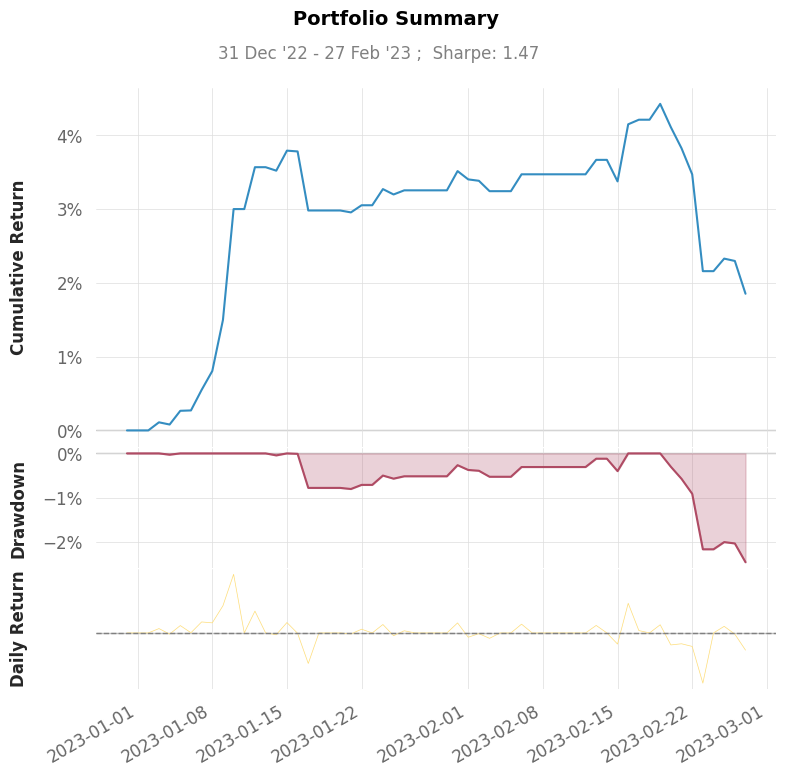

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


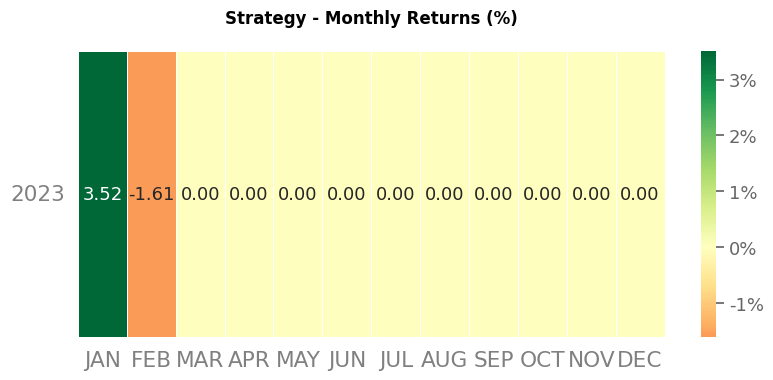

                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2023-02-27
Risk-Free Rate      0.0%
Time in Market      80.0%

Cumulative Return   5.41%
CAGR﹪              26.23%

Sharpe              2.3
Prob. Sharpe Ratio  86.46%
Sortino             3.82
Sortino/√2          2.7
Omega               1.61

Max Drawdown        -3.39%
Longest DD Days     27

Gain/Pain Ratio     0.61
Gain/Pain (1M)      1.58

Payoff Ratio        1.61
Profit Factor       1.61
Common Sense Ratio  2.19
CPC Index           1.29
Tail Ratio          1.36
Outlier Win Ratio   4.34
Outlier Loss Ratio  4.24

MTD                 -3.39%
3M                  5.41%
6M                  5.41%
YTD                 5.41%
1Y                  5.41%
3Y (ann.)           26.23%
5Y (ann.)           26.23%
10Y (ann.)          26.23%
All-time (ann.)     26.23%

Avg. Drawdown       -0.75%
Avg. Drawdown Days  5
Recovery Factor     1.59
Ulcer Index         0.02
Serenity Index      0.79


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


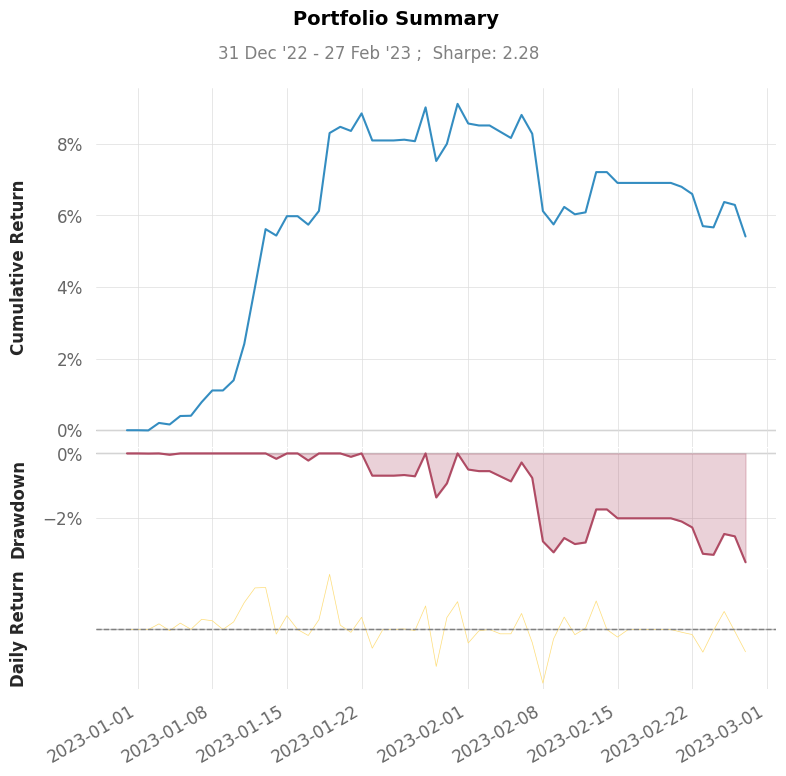

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


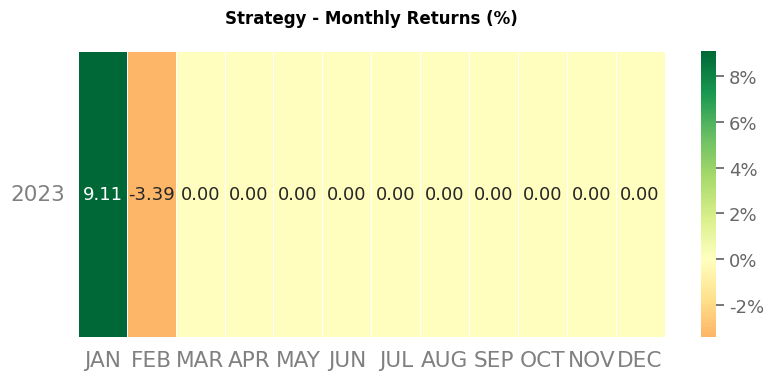

                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2023-02-27
Risk-Free Rate      0.0%
Time in Market      64.0%

Cumulative Return   6.75%
CAGR﹪              33.47%

Sharpe              3.46
Prob. Sharpe Ratio  98.7%
Sortino             9.15
Sortino/√2          6.47
Omega               2.66

Max Drawdown        -1.75%
Longest DD Days     16

Gain/Pain Ratio     1.66
Gain/Pain (1M)      -

Payoff Ratio        2.52
Profit Factor       2.66
Common Sense Ratio  4.18
CPC Index           3.46
Tail Ratio          1.57
Outlier Win Ratio   8.59
Outlier Loss Ratio  3.9

MTD                 1.96%
3M                  6.75%
6M                  6.75%
YTD                 6.75%
1Y                  6.75%
3Y (ann.)           33.47%
5Y (ann.)           33.47%
10Y (ann.)          33.47%
All-time (ann.)     33.47%

Avg. Drawdown       -0.41%
Avg. Drawdown Days  4
Recovery Factor     3.78
Ulcer Index         0.01
Serenity Index      3.18


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


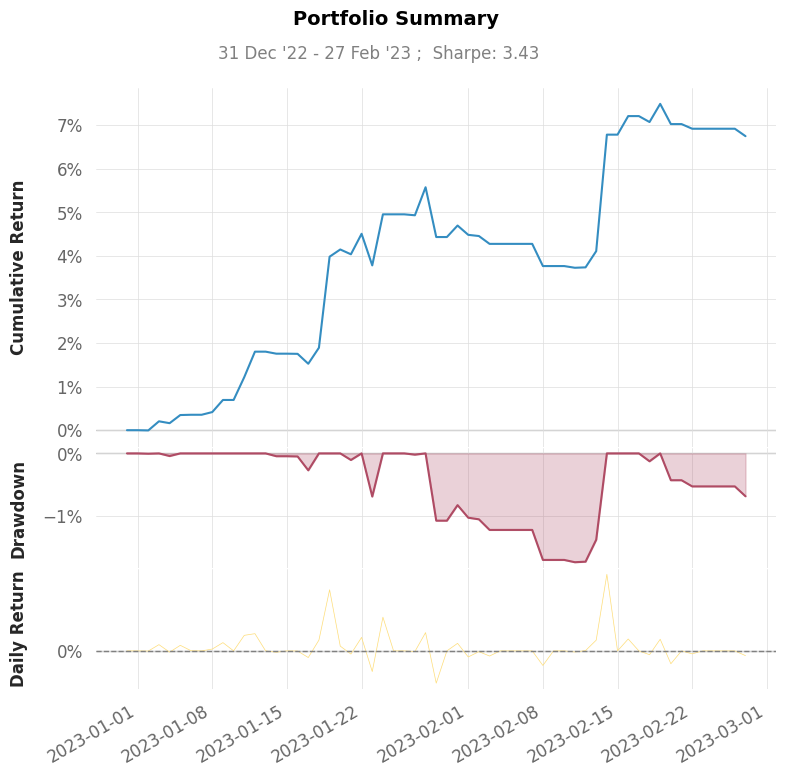

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


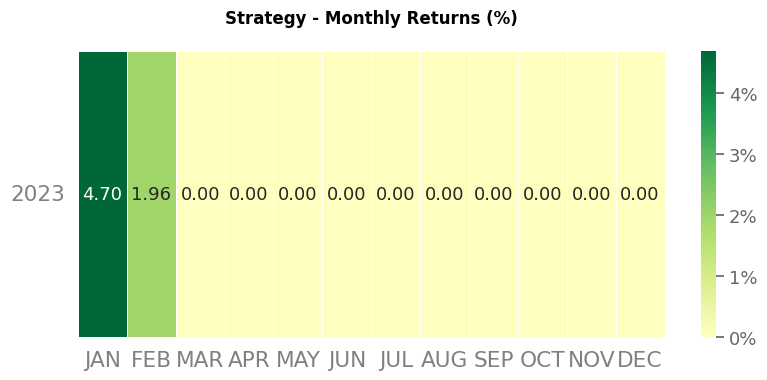

In [113]:
import quantstats as qs

dates = pd.date_range(start=test_data.index[0], periods=len(original_values), freq="D")
portfolio_series = pd.Series(original_values, index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)

dates = pd.date_range(start=test_data.index[0], periods=len(onnx_values), freq="D")
portfolio_series = pd.Series(onnx_values    , index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)

dates = pd.date_range(start=test_data.index[0], periods=len(ic_values), freq="D")
portfolio_series = pd.Series(ic_values, index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)